In [1]:
%matplotlib inline

import random
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import scale

from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.kernel_ridge import KernelRidge

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet 

from sklearn.svm import SVR
import lightgbm as lgb

from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns', None)

import gc
gc.enable()

In [2]:
def fill_missing_values(df_old):
    df = df_old.copy()
    
    column_list = ["NAME_TYPE_SUITE", "AMT_ANNUITY", "AMT_GOODS_PRICE", "OCCUPATION_TYPE"]
    # For categorical column, fill missing value with mode
    # For numerical column, fill missing value with median
    for col in column_list:
        if (df[col].dtypes == "object"):
            df[col] = df[col].fillna(df[col].mode()[0])
        elif (df[col].dtypes == "float64"):
            df[col] = df[col].fillna(df[col].median())
        else:
            print(df[col].dtypes)
            
    # For DAYS_EMPLOYED column
    # Description: How many days before the application the person started current employment
    # This column contains 55374 entries of value 365243 which does not make sense
    # Add a new column called DAYS_EMPLOYED_ANOMALOUS to capture these 55374 entries
    # Replace all 365243 with Nan and fill nan with median
    df['DAYS_EMPLOYED_ANOMALOUS'] = (df["DAYS_EMPLOYED"] == 365243)
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace({365243: np.nan})
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].fillna(df['DAYS_EMPLOYED'].mean())
    
    # For OWN_CAR_AGE column
    # Description: Age of client's car
    # Decided to fill all missing value with the max which is 91
    # That means we assume that they either don't have a car or own a very old car
    df['OWN_CAR_AGE'] = df['OWN_CAR_AGE'].fillna(df['OWN_CAR_AGE'].max())
    
    # For CNT_FAM_MEMBERS column
    # Description: How many family members does client have
    # Only 2 missing value so use the mode of family member count which is 2 family members to fill it
    df['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].fillna(2)
    
    # For DAYS_LAST_PHONE_CHANGE column
    # Description: How many days before application did client change phone
    # Only 1 missing value so use the mode which is 0 to fill it
    df['DAYS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'].fillna(0)
    
    # Replace all missing/NA values with 0 for the number of enquiries before application
    df['AMT_REQ_CREDIT_BUREAU_YEAR'] = df['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(0)
    df['AMT_REQ_CREDIT_BUREAU_HOUR'] = df['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(0)
    df['AMT_REQ_CREDIT_BUREAU_DAY'] = df['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(0)
    df['AMT_REQ_CREDIT_BUREAU_WEEK'] = df['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(0)
    df['AMT_REQ_CREDIT_BUREAU_MON'] = df['AMT_REQ_CREDIT_BUREAU_MON'].fillna(0)
    df['AMT_REQ_CREDIT_BUREAU_QRT'] = df['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(0)
    df['AMT_REQ_CREDIT_BUREAU_YEAR'] = df['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(0)
    
    # For EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 columns
    # Since the value is already normalized, fill all missing value with mean
    df['EXT_SOURCE_1'] = df['EXT_SOURCE_1'].fillna(df['EXT_SOURCE_1'].mean())
    df['EXT_SOURCE_2'] = df['EXT_SOURCE_2'].fillna(df['EXT_SOURCE_2'].mean())
    df['EXT_SOURCE_3'] = df['EXT_SOURCE_3'].fillna(df['EXT_SOURCE_3'].mean())
    
    # For OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE,
    # OBS_60_CNT_SOCIAL_CIRCLE and DEF_60_CNT_SOCIAL_CIRCLE columns
    # Description: How many observation of client's social surroundings with observable/defaulted
    # Use the mode which is 0 to fill these 4 columns
    df['OBS_30_CNT_SOCIAL_CIRCLE'] = df['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(0)
    df['DEF_30_CNT_SOCIAL_CIRCLE'] = df['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0)
    df['OBS_60_CNT_SOCIAL_CIRCLE'] = df['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(0)
    df['DEF_60_CNT_SOCIAL_CIRCLE'] = df['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0)
    
    return df

def fill_all_missing_values(grand_table):
    value_info = {}
    values_to_fill = pd.read_csv('missing_value_for_agg.csv')
    for index, row in values_to_fill.iterrows():
        table = row['Table']
        row_name = row['Row']
        row_type = row['Type']
        if not value_info.get(table):
            value_info[table] = {}
        value_info[table][row_name] = (row_type, row['missing value after aggregation'])
    
    for table in value_info.keys():
        # reverse sort so that "AB_CD" appears before "AB", requried for later processing
        columns = list(sorted(value_info[table].keys(), reverse=True))
        value_info[table]['all_columns'] = columns
        
    def fill_value(df, column, value):
        if value == 'median':
            df[column] = df[column].fillna(df[column].median())
        else:
            df[column] = df[column].fillna(int(value))
        return df
    
    def process_column(df, column, table):
        for col_name in value_info[table]['all_columns']:
            if col_name in column:
                return fill_value(df, column, value_info[table][col_name][1])
        print("Column %s in table %s not processed" % (column, table))
        
    def process(df):
        for column in df.columns:
            column = str(column)

            if not df[column].isnull().values.any():  # no missing value
                continue
            if column[0:len('prev_app')] == 'prev_app':
                df = process_column(df, column, 'previous_application.csv')
            elif column[0:len('install')] == 'install':
                df = process_column(df, column, 'installments_payments.csv')
            elif column[0:len('credit_bal')] == 'credit_bal':
                df = process_column(df, column, 'credit_card_balance.csv')
            elif column[0:len('pos_cash')] == 'pos_cash':
                if 'CNT_INSTALMENT_FUTURE' in column:  # this column is an ID, should drop
                    df = df.drop(column, axis=1)
                    continue
                df = process_column(df, column, 'POS_CASH_balance.csv')
            elif column[0:len('bureau')] == 'bureau':
                df = process_column(df, column, 'bureau.csv')
            elif column[0:len('client_bureau_balance')] == 'client_bureau_balance':
                # remove all columns from MONTHS_BALANCE except for 'MONTHS_BALANCE_min' because
                # MONTHS_BALANCE is like an ID, but its min has meaning
                if 'MONTHS_BALANCE' in column and 'MONTHS_BALANCE_min' not in column:
                    df = df.drop(column, axis=1)
                    continue
                df = process_column(df, column, 'bureau_balance.csv')
            else:
                print("column %s from grand table not processed" % column)
        return df
    
    return process(grand_table)

def label_encoding(df_old):
    df = df_old.copy()
    
    # For CODE_GENDER column, group 'XNA' categorical value to 'Female' which is the mode since there is only 4 rows
    df['CODE_GENDER'] = df['CODE_GENDER'].replace({'XNA': 'F'})
    
    category_map = {
        'CODE_GENDER': {'F': 0, 'M': 1},
        'FLAG_OWN_CAR': {'N': 0, 'Y': 1},
        'FLAG_OWN_REALTY': {'N': 0, 'Y': 1},
        'NAME_EDUCATION_TYPE': {
            'Academic degree': 0, 
            'Lower secondary': 1,
            'Secondary / secondary special': 2,
            'Incomplete higher': 3,
            'Higher education': 4
        },
        'DAYS_EMPLOYED_ANOMALOUS': {False: 0, True: 1},
    }
    for col in category_map.keys():
        df[col] = df[col].map(category_map[col])
    
    """
    encoding_order = {
        'CODE_GENDER'     : ['F', 'M'],
        'FLAG_OWN_CAR'    : ['N', 'Y'],
        'FLAG_OWN_REALTY' : ['N', 'Y'],
        'NAME_EDUCATION_TYPE' : ['Academic degree', 'Lower secondary', 'Secondary / secondary special', 
                                 'Incomplete higher', 'Higher education'],
    }
    le_features = list(encoding_order.keys())
    le = LabelEncoder()
    for feature in le_features:
        le.fit(encoding_order[feature])
        df[feature] = le.transform(df[feature])
    """
    return df

def one_hot_encoding(df_old):
    df = df_old.copy()
    
    # For NAME_FAMILY_STATUS column, group 'Unknown' categorical value to 'Married' which is the mode since there is only 2 rows
    df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].replace({'Unknown': 'Married'})
    
    column_list = [
        "NAME_CONTRACT_TYPE", "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", 
        "NAME_HOUSING_TYPE", "NAME_FAMILY_STATUS", "OCCUPATION_TYPE",
        "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"
    ]
    for col in column_list:
        df = pd.get_dummies(df, columns=[col])
    return df

def create_new_features(df_old):
    df = df_old.copy()
    
    # Create new feature column: TOTAL_DOCUMENTS that aggregates the 20 FLAG_DOCUMENT fields (2-21)
    df['TOTAL_DOCUMENTS'] = df['FLAG_DOCUMENT_2'] + df['FLAG_DOCUMENT_3'] + df['FLAG_DOCUMENT_4'] + df['FLAG_DOCUMENT_5'] +\
                            df['FLAG_DOCUMENT_6'] + df['FLAG_DOCUMENT_7'] + df['FLAG_DOCUMENT_8'] + df['FLAG_DOCUMENT_9'] +\
                            df['FLAG_DOCUMENT_10'] + df['FLAG_DOCUMENT_11'] + df['FLAG_DOCUMENT_12'] + df['FLAG_DOCUMENT_13'] +\
                            df['FLAG_DOCUMENT_14'] + df['FLAG_DOCUMENT_15'] + df['FLAG_DOCUMENT_16'] + df['FLAG_DOCUMENT_17'] +\
                            df['FLAG_DOCUMENT_18'] + df['FLAG_DOCUMENT_19'] + df['FLAG_DOCUMENT_20'] + df['FLAG_DOCUMENT_21']
    
    #for i in range(2, 22):
    #    df = df.drop('FLAG_DOCUMENT_' + str(i), axis=1)
    
    return df

def remove_useless_columns(df_old):
    df = df_old.copy()
    
    remove_columns_list = [
        "APARTMENTS_AVG", "BASEMENTAREA_AVG", "YEARS_BEGINEXPLUATATION_AVG", "YEARS_BUILD_AVG",
        "COMMONAREA_AVG", "ELEVATORS_AVG", "ENTRANCES_AVG", "FLOORSMAX_AVG", "FLOORSMIN_AVG",
        "LANDAREA_AVG", "LIVINGAPARTMENTS_AVG", "LIVINGAREA_AVG", "NONLIVINGAPARTMENTS_AVG", "NONLIVINGAREA_AVG",
        "APARTMENTS_MODE", "BASEMENTAREA_MODE", "YEARS_BEGINEXPLUATATION_MODE", "YEARS_BUILD_MODE", "COMMONAREA_MODE",
        "ELEVATORS_MODE", "ENTRANCES_MODE", "FLOORSMAX_MODE", "FLOORSMIN_MODE", "LANDAREA_MODE", "LIVINGAPARTMENTS_MODE",
        "LIVINGAREA_MODE", "NONLIVINGAPARTMENTS_MODE", "NONLIVINGAREA_MODE", "APARTMENTS_MEDI", "BASEMENTAREA_MEDI",
        "YEARS_BEGINEXPLUATATION_MEDI", "YEARS_BUILD_MEDI", "COMMONAREA_MEDI", "ELEVATORS_MEDI", "ENTRANCES_MEDI",
        "FLOORSMAX_MEDI", "FLOORSMIN_MEDI", "LANDAREA_MEDI", "LIVINGAPARTMENTS_MEDI", "LIVINGAREA_MEDI",
        "NONLIVINGAPARTMENTS_MEDI", "NONLIVINGAREA_MEDI", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "TOTALAREA_MODE",
        "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE"
    ]
    for column_name in remove_columns_list:
        df = df.drop(column_name, axis=1)
    return df

def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col, axis=1).copy()
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

# For POS_CASH Balance Only

def agg_numeric_with_count(df, group_var, df_name):
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'median', 'max']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

# New Features & Pre-processing for Previous Application data

def prev_app_process(df_prev_app):
    
    # 1. Only consider the final application recrods (with flag of last application = Y)
    
    print('Before Apply Filter: ' + str(len(df_prev_app)))
    
    df_prev_app = df_prev_app[df_prev_app['FLAG_LAST_APPL_PER_CONTRACT']=='Y'].copy()
    
    print('After Apply Filter: ' + str(len(df_prev_app)))
    
    # 2. Drop the two flags as not important anymore (shd be always = Y )
    # 3. Only Consumer Loan has columns interest rate data, 99% missing => Drop
    df_prev_app = df_prev_app.drop(['FLAG_LAST_APPL_PER_CONTRACT','NFLAG_LAST_APPL_IN_DAY','RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED'],axis=1).copy()    
    
    # 4. Fill in 0 for missing down payment (i.e. no down payment / not required = down payment)
    df_prev_app['RATE_DOWN_PAYMENT']=df_prev_app['RATE_DOWN_PAYMENT'].fillna(0).copy()
    
    # 5. Ratio of Credit amount received / Applied
    #    To avoid error, fill missing to be 0
    #    when AMT_APPLICATION = 0, default the ratio to be 0 (i.e. not fulfil application)
    df_prev_app['AMT_CREDIT']=df_prev_app['AMT_CREDIT'].fillna(0).copy()
    #df_prev_app['AMT_CREDIT_APPLICATION_RATIO'] = np.where(df_prev_app['AMT_APPLICATION']==0, df_prev_app['AMT_CREDIT'] / df_prev_app['AMT_APPLICATION'],0)
    df_prev_app['AMT_CREDIT_APPLICATION_RATIO'] = np.where(df_prev_app['AMT_APPLICATION']==0, 0, df_prev_app['AMT_CREDIT'] / df_prev_app['AMT_APPLICATION'])
    
    # 6. Transform DAYS_DECISION from days to month
    df_prev_app['APPLICATION_NO_OF_MONTH_AGO']=(-df_prev_app['DAYS_DECISION']/30).apply(np.ceil)
    
    # 7. Replace 365243 to be nan
    for col in ('DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION'):

        df_prev_app.replace({col:{365243 : np.nan,}}, inplace=True)
    
    # 8. Fill -1 to missing value in field: NFLAG_INSURED_ON_APPROVAL
    df_prev_app['NFLAG_INSURED_ON_APPROVAL']=df_prev_app['NFLAG_INSURED_ON_APPROVAL'].fillna(-1).copy()
    
    return df_prev_app


def prev_application_Summary(df_prev):
    
    processed = prev_app_process(df_prev)
    
    prev_app_count = count_categorical(processed.drop('SK_ID_PREV',axis=1), group_var = 'SK_ID_CURR', df_name = 'prev_app').reset_index()
    
    prev_app_agg = agg_numeric(processed.drop('SK_ID_PREV',axis=1), group_var = 'SK_ID_CURR', df_name = 'prev_app')
    
    # Get the count of previous applications within last month, 6 months, 1 year(only consider the last one for the contract)
    for i in [1,6,12]:
        
        temp = processed[processed['APPLICATION_NO_OF_MONTH_AGO'] <= i]
        
        if i == 1:
            
            prev_app_count_record = temp.groupby('SK_ID_CURR').size().reset_index(name='prev_app_'+str(i)+'_Month_Count')
            
        else:
            
            temp_count = temp.groupby('SK_ID_CURR').size().reset_index(name='prev_app_'+str(i)+'_Month_Count')
            
            prev_app_count_record=prev_app_count_record.merge(temp_count,  
                                                              on = 'SK_ID_CURR', 
                                                              how = 'outer')

    # Merge the three tables tgt
    
    output = prev_app_count.merge(prev_app_agg, on='SK_ID_CURR', how='outer')
    
    output = output.merge(prev_app_count_record, on='SK_ID_CURR', how='outer').copy()
        
    return output


# installment feature creation

def installment_process(df_install):
    
    # 0. NUM_INSTALMENT_VERSION 0,1,Others
    
    # 1. Fill NA with 0
    # i.e. up till now still no payment
    df_install['DAYS_ENTRY_PAYMENT']=df_install['DAYS_ENTRY_PAYMENT'].fillna(0).copy()
    df_install['AMT_PAYMENT']=df_install['AMT_PAYMENT'].fillna(0).copy()
    
    # 2. Late Payment Days
    # =max(DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT,0)
    df_install['DAYS_LATE_PAYMENT']=np.where(df_install['DAYS_ENTRY_PAYMENT'] - df_install['DAYS_INSTALMENT'] > 0, df_install['DAYS_ENTRY_PAYMENT'] - df_install['DAYS_INSTALMENT'], 0)
    
    # 3. AMT_PAYMENT_INSTALMENT_RATIO
    df_install['AMT_PAYMENT_INSTALMENT_RATIO'] = np.where(df_install['AMT_INSTALMENT']==0, 1, df_install['AMT_PAYMENT']/df_install['AMT_INSTALMENT'])
    
    # 4. Drop NUM_INSTALMENT_NUMBER
    df_install = df_install.drop('NUM_INSTALMENT_NUMBER', axis=1).copy()
    
    # 5. Group NUM_INSTALMENT_VERSION into 3 groups: 0,1,Others
    df_install.loc[df_install['NUM_INSTALMENT_VERSION'] >1,'NUM_INSTALMENT_VERSION']='Others'
    
    
    return df_install


# Installment Summary

def install_summary(df_install):
    
    processed = installment_process(df_install)
    
    install_count = count_categorical(processed.drop('SK_ID_PREV',axis=1), group_var = 'SK_ID_CURR', df_name = 'install').reset_index()
    
    install_agg = agg_numeric(processed.drop('SK_ID_PREV',axis=1), group_var = 'SK_ID_CURR', df_name = 'install')

    # Merge the 2 tables tgt
    
    output = install_count.merge(install_agg, on='SK_ID_CURR', how='outer')
        
    return output

# Credit Card table preprocessing

def credit_card_process(df_credit_card):
    
    # 0. Fill Na with 0 for Current Drawing releated fields & AMT_PAYMENT_CURRENT 
    for col in ['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_PAYMENT_CURRENT', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT','CNT_DRAWINGS_POS_CURRENT']:
        df_credit_card[col]=df_credit_card[col].fillna(0).copy() 
    
    # 1. Drop: AMT_RECEIVABLE_PRINCIPAL
    #          AMT_RECIVABLE
    #          AMT_TOTAL_RECEIVABLE
    #          Can be well represented by AMT_BALANCE
    df_credit_card = df_credit_card.drop(['AMT_RECEIVABLE_PRINCIPAL','AMT_RECIVABLE','AMT_TOTAL_RECEIVABLE'],axis=1).copy()
    
    
    # 2. Combine AMT_PAYMENT_CURRENT & AMT_PAYMENT_TOTAL_CURRENT (Pick Max Value)
    #    Then drop the two fields
    df_credit_card['AMT_PAYMENT']=np.where(df_credit_card['AMT_PAYMENT_TOTAL_CURRENT'] > df_credit_card['AMT_PAYMENT_CURRENT'], df_credit_card['AMT_PAYMENT_CURRENT'], df_credit_card['AMT_PAYMENT_CURRENT'])
    df_credit_card = df_credit_card.drop(['AMT_PAYMENT_TOTAL_CURRENT', 'AMT_PAYMENT_CURRENT'], axis=1).copy()
    
    
    # 3. Average_Drawing_For_Goods = AMT_DRAWINGS_POS_CURRENT / CNT_DRAWINGS_POS_CURRENT
    #    Average_Drawing = AMT_DRAWINGS_CURRENT / CNT_DRAWINGS_CURRENT
    df_credit_card['Average_Drawing_For_Goods'] = np.where(df_credit_card['CNT_DRAWINGS_POS_CURRENT']==0, 0, df_credit_card['AMT_DRAWINGS_POS_CURRENT']/df_credit_card['CNT_DRAWINGS_POS_CURRENT'])
    df_credit_card['Average_Drawing'] = np.where(df_credit_card['CNT_DRAWINGS_CURRENT']==0, 0, df_credit_card['AMT_DRAWINGS_CURRENT']/df_credit_card['CNT_DRAWINGS_CURRENT'])

    
    # 4. AMT_DRAWINGS_CURRENT ~ AMT_DRAWINGS_POS_CURRENT + AMT_DRAWINGS_ATM_CURRENT + AMT_DRAWINGS_OTHER_CURRENT
    # Fill missing values of the three columns as 0
    # New Feature: Special_Expense = difference between RHS & LHS
    # Then Drop AMT_DRAWINGS_ATM_CURRENT, AMT_DRAWINGS_OTHER_CURRENT
    df_credit_card['Special_Expense'] = (df_credit_card['AMT_DRAWINGS_CURRENT'] - df_credit_card['AMT_DRAWINGS_POS_CURRENT'] - df_credit_card['AMT_DRAWINGS_ATM_CURRENT'] - df_credit_card['AMT_DRAWINGS_OTHER_CURRENT']).abs()
    df_credit_card = df_credit_card.drop(['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT'], axis=1).copy()
    
    
    # 4. Calculate the ratio
    #    Drawing_For_Goods_RATIO = CNT_DRAWINGS_POS_CURRENT / CNT_DRAWINGS_CURRENT
    # Drop:
    # CNT_DRAWINGS_ATM_CURRENT
    # CNT_DRAWINGS_CURRENT
    # CNT_DRAWINGS_OTHER_CURRENT
    # CNT_DRAWINGS_POS_CURRENT
    df_credit_card['Drawing_For_Goods_RATIO'] = np.where(df_credit_card['CNT_DRAWINGS_CURRENT']==0, 0, df_credit_card['CNT_DRAWINGS_POS_CURRENT'] / df_credit_card['CNT_DRAWINGS_CURRENT'])
    df_credit_card = df_credit_card.drop(['CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT'], axis=1).copy()    
    
    
    # 5. Drop column: MONTHS_BALANCE
    df_credit_card=df_credit_card.drop('MONTHS_BALANCE', axis=1).copy()
    
    return df_credit_card


# Credit Card Balance Summary

def credit_bal_summary(df_credit_card):
    
    # Pre-process / Feature Creation
    processed = credit_card_process(df_credit_card)
    
    # Categorical Variables Aggregration
    credit_count = count_categorical(processed.drop('SK_ID_PREV',axis=1), group_var = 'SK_ID_CURR', df_name = 'credit_bal').reset_index()
    
    # Numeric Variables Aggregration
    credit_agg = agg_numeric(processed.drop('SK_ID_PREV',axis=1), group_var = 'SK_ID_CURR', df_name = 'credit_bal')

    # Merge the 2 tables tgt
    output = credit_count.merge(credit_agg, on='SK_ID_CURR', how='outer')
        
    return output

# POS Cash Summary

def POS_Cash_Summary(df_pos_cash):
    
    # Mainly just fill in missing value
    df_pos_cash=df_pos_cash=df_pos_cash.fillna(0).drop('SK_ID_PREV',axis=1).copy()
    
    # 1. Extract only for those contracts as of now
    Last_Bal = df_pos_cash[df_pos_cash['MONTHS_BALANCE']==-1].drop('MONTHS_BALANCE', axis=1)
    
    # Categorical Variables Aggregration
    Last_Bal_count = count_categorical(Last_Bal, group_var = 'SK_ID_CURR', df_name = 'pos_cash_last_bal').reset_index()
    
    # Numeric Variables Aggregration
    Last_Bal_agg = agg_numeric(Last_Bal, group_var = 'SK_ID_CURR', df_name = 'pos_cash_last_bal')

    # Merge the 2 tables tgt
    Last_Bal_output = Last_Bal_count.merge(Last_Bal_agg, on='SK_ID_CURR', how='outer')
    
    # 2. Overall POS Cash Balance Past Due Day Issue
    # - Count how many months bal with DPD
    # - Median
    # - Max
    
    With_DPD = df_pos_cash[df_pos_cash['SK_DPD'] > 0][['SK_ID_CURR', 'SK_DPD', 'SK_DPD_DEF']]
    
    With_DPD_agg = agg_numeric_with_count(With_DPD, group_var = 'SK_ID_CURR', df_name = 'pos_cash_DPD')
    
    output =  Last_Bal_output.merge(With_DPD_agg, on='SK_ID_CURR', how='outer')
    
    return output


def get_bureau_all_df(bureau, bureau_balance):

    bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')

    bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
    
    bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

    bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

    # Dataframe grouped by the loan
    bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
    
    # Merge to include the SK_ID_CURR
    bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')
    
    # Aggregate the stats for each client
    bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

    train_bureau = bureau_counts.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

    # Merge with the monthly information grouped by client
    train_bureau = train_bureau.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

    return   train_bureau



In [3]:
# Read all CSV Files
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")
application = pd.concat([train, test], ignore_index=True, sort=False)

# Preprocess application train and test CSV
application = fill_missing_values(application)
application = label_encoding(application)
application = one_hot_encoding(application)
application = create_new_features(application)
application = remove_useless_columns(application)

In [4]:
# Preprocess previous application CSV
prev_app = pd.read_csv('previous_application.csv')
prev_app_for_merge = prev_application_Summary(prev_app)
del prev_app
gc.collect()

Before Apply Filter: 1670214
After Apply Filter: 1661739


/home/khlau/Documents/msbd5012/lib/python3.6/site-packages/ipykernel_launcher.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


84

In [5]:
# Preprocess installment payments CSV
installment = pd.read_csv('installments_payments.csv')
install_for_merge = install_summary(installment)
del installment
gc.collect()

/home/khlau/Documents/msbd5012/lib/python3.6/site-packages/ipykernel_launcher.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


140

In [6]:
# Preprocess credit card balance CSV
credit_bal = pd.read_csv('credit_card_balance.csv')
credit_bal_for_merge = credit_bal_summary(credit_bal)
del credit_bal
gc.collect()

/home/khlau/Documents/msbd5012/lib/python3.6/site-packages/ipykernel_launcher.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


98

In [7]:
pos_cash = pd.read_csv('POS_CASH_balance.csv')
# Preprocess POS Cash Balance CSV
POS_cash_for_merge = POS_Cash_Summary(pos_cash)
del pos_cash
gc.collect()

/home/khlau/Documents/msbd5012/lib/python3.6/site-packages/ipykernel_launcher.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


126

In [8]:
# Preprocess bureau and bureau balance CSV
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau_for_merge = get_bureau_all_df(bureau, bureau_balance)
del bureau,bureau_balance
gc.collect()

/home/khlau/Documents/msbd5012/lib/python3.6/site-packages/ipykernel_launcher.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


105

In [9]:
# Merge all tables into one main table
main_table = application.merge(prev_app_for_merge, on = 'SK_ID_CURR', how = 'left')
del prev_app_for_merge
gc.collect()

main_table = main_table.merge(install_for_merge, on = 'SK_ID_CURR', how = 'left')
del install_for_merge
gc.collect()

main_table = main_table.merge(credit_bal_for_merge, on = 'SK_ID_CURR', how = 'left')
del credit_bal_for_merge
gc.collect()

main_table = main_table.merge(POS_cash_for_merge, on = 'SK_ID_CURR', how = 'left')
del POS_cash_for_merge
gc.collect()


main_table = main_table.merge(bureau_for_merge, on = 'SK_ID_CURR', how = 'left')
del bureau_for_merge
gc.collect()

14

In [10]:
main_table = fill_all_missing_values(main_table)

main_table_train = main_table[main_table['TARGET'].notnull()]
main_table_test = main_table[main_table['TARGET'].isnull()]

column TARGET from grand table not processed


In [11]:
main_table_train.to_csv("main_table2.csv")
main_table_test.to_csv("test_table2.csv")

In [4]:
print(application.shape)
print(prev_app_for_merge.shape)
print(install_for_merge.shape)
print(credit_bal_for_merge.shape)
print(POS_cash_for_merge.shape)
print(bureau_for_merge.shape)
print(main_table.shape)

(356255, 180)
(338857, 358)
(339587, 31)
(103558, 67)
(127035, 37)
(305811, 175)
(356255, 843)


In [2]:
# TARGET
# Target variable 
# 1 - client with payment difficulties: he/she had late payment more than X days
# on at least one of the first Y installments of the loan in our sample
# 0 - all other cases
# Only 8% has 1 as the value so need to use oversampling
col_name="TARGET"
print(train[col_name].value_counts())
print(train[col_name].value_counts() / len(train[col_name]))

missing_count = train[col_name].isnull().sum()
total_count = len(train[col_name])
print("Missing Value: %d/%d (%f)" % (missing_count, total_count, missing_count / total_count))

0    282686
1     24825
Name: TARGET, dtype: int64
0    0.919271
1    0.080729
Name: TARGET, dtype: float64
Missing Value: 0/307511 (0.000000)


In [3]:
# NAME_TYPE_SUITE
# Who was accompanying client when he was applying for the loan
# - don't think it is very related
# - should be categorical so use one-hot
# - consider dropping this column since the information does not seems to be very useful
col_name = "NAME_TYPE_SUITE"
print(train[col_name].value_counts())
missing_count = train[col_name].isnull().sum()
total_count = len(train[col_name])
print("Missing Value: %d/%d (%f)" % (missing_count, total_count, missing_count / total_count))

# Convert each categorical value into a new column using one-hot method
#train = pd.get_dummies(train, columns=["NAME_TYPE_SUITE"])

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64
Missing Value: 1292/307511 (0.004201)


In [4]:
# NAME_INCOME_TYPE
# Clients income type (businessman, working, maternity leave,?)
col_name = "NAME_INCOME_TYPE"
print(train[col_name].value_counts())
missing_count = train[col_name].isnull().sum()
total_count = len(train[col_name])
print("Missing Value: %d/%d (%f)" % (missing_count, total_count, missing_count / total_count))

# Convert each categorical value into a new column using one-hot method
#train = pd.get_dummies(train, columns=["NAME_INCOME_TYPE"])

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64
Missing Value: 0/307511 (0.000000)


In [5]:
# NAME_EDUCATION_TYPE
# Level of highest education the client achieved
# - should be ordinal
# - maybe just categorical?
# - no missing value
# Academic degree: 1
# Lower secondary: 2
# Secondary / secondary special: 3
# Incomplete higher: 4
# Higher education: 5
col_name = "NAME_EDUCATION_TYPE"
print(train[col_name].value_counts())
print("Missing value: " + str(train[col_name].isnull().sum()))

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64
Missing value: 0


In [6]:
# NAME_FAMILY_STATUS
# Family status of the client
# Categorical and no missing value, so one-hot
col_name = "NAME_FAMILY_STATUS"
print(train[col_name].value_counts())
print("Missing value: " + str(train[col_name].isnull().sum()))

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64
Missing value: 0


In [7]:
# NAME_HOUSING_TYPE
# "What is the housing situation of the client (renting, living with parents, ...)"
# - categorical with no missing value so one-hot
col_name = "NAME_HOUSING_TYPE"
print(train[col_name].value_counts())
print("Missing value: " + str(train[col_name].isnull().sum()))

House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64
Missing value: 0


In [ ]:
# REGION_POPULATION_RELATIVE,
# Normalized population of region where client lives 
# (higher number means the client lives in more populated region),normalized
# - Richer people usually living in less dense populated region, not necessary for rural 
# - negative correlation with target
print("Correlation with target: %f" % (train[col_name].corr(train['TARGET'])))

In [ ]:
# DAYS_BIRTH
# Client's age in days at the time of application,time only relative to the application
# This is an important feature since older people tends to be able to pay loan
# Number is backward starting from application date so all numbers are negative
# From age 20 (-7489) to age 69 (-25229)
# The correlation is positive, but the value of this feature is actually negative, 
# meaning that as the client gets older, they are less likely to default on their loan
# (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.
col_name = "DAYS_BIRTH"
print(train[col_name].describe())
print("Missing value: " + str(train[col_name].isnull().sum()))

# Find the correlation of the positive days since birth and target
# As the client gets older, there is a negative linear relationship with the target 
# meaning that as clients get older, they tend to repay their loans on time more often.
train[col_name] = abs(train[col_name])
print("Correlation with target: %f" % (train[col_name].corr(train['TARGET'])))

# A clear trend: 
# younger applicants are more likely to not repay the loan! 
# The rate of failure to repay is above 10% for the youngest three age groups 
# and beolow 5% for the oldest age group.

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64
Missing value: 55374


Text(0.5,0,'Days Employment')

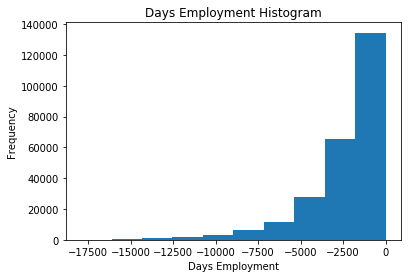

In [10]:
# DAYS_EMPLOYED
# How many days before the application the person started current employment
# time only relative to the application
# - Value 365243 does not make sense and contain a count of 55374
# - should be consider missing value
# - use 0 to replace it perhaps?

col_name = "DAYS_EMPLOYED"
print(train[col_name].describe())

# Create an anomalous flag column
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
print("Missing value: " + str(train[col_name].isnull().sum()))

train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

In [ ]:
# DAYS_REGISTRATION
# How many days before the application did client change his registration
# time only relative to the application
# - not sure what registration mean but it is already numerical
print("Correlation with target: %f" % (train["DAYS_REGISTRATION"].corr(train['TARGET'])))

In [ ]:
# DAYS_ID_PUBLISH
# How many days before the application did client change the identity document
# with which he applied for the loan, time only relative to the application
# - Seems to be quite important
# - Not sure what that means, how come someone can change his/her identity doc?
print("Correlation with target: %f" % (train["DAYS_ID_PUBLISH"].corr(train['TARGET'])))

In [2]:
# OWN_CAR_AGE
# Age of client's car
# - need to decide whether to use imputation to fill in missing value or remove the entire column
# - another alternative is to use algorithm that can handle missing value e.g. XGBoost
# fill missing value with max
col_name = "OWN_CAR_AGE"
print(train[col_name].describe())
missing_count = train[col_name].isnull().sum()
total_count = len(train[col_name])
print("Missing Value: %d/%d (%f)" % (missing_count, total_count, missing_count / total_count))

count    104582.000000
mean         12.061091
std          11.944812
min           0.000000
25%           5.000000
50%           9.000000
75%          15.000000
max          91.000000
Name: OWN_CAR_AGE, dtype: float64
Missing Value: 202929/307511 (0.659908)


In [3]:
train["OWN_CAR_AGE"].value_counts()

7.0     7424
6.0     6382
3.0     6370
8.0     5887
2.0     5852
4.0     5557
1.0     5280
9.0     5020
10.0    4806
14.0    4594
13.0    4566
12.0    4257
11.0    4161
5.0     3595
15.0    3580
16.0    3355
17.0    2899
64.0    2443
18.0    2418
0.0     2134
19.0    1864
20.0    1527
21.0    1462
22.0    1250
24.0    1150
23.0    1067
65.0     891
25.0     865
26.0     580
28.0     542
        ... 
30.0     326
31.0     267
32.0     208
34.0     183
35.0     157
33.0     132
36.0     124
38.0      97
40.0      85
39.0      78
37.0      75
41.0      58
42.0      42
44.0      21
43.0      19
54.0      12
45.0      11
49.0       6
46.0       5
55.0       4
51.0       3
63.0       2
91.0       2
69.0       1
48.0       1
52.0       1
56.0       1
47.0       1
50.0       1
57.0       1
Name: OWN_CAR_AGE, Length: 62, dtype: int64

In [6]:
payment = pd.read_csv("installments_payments.csv")
payment.isnull().sum().sort_values()

13605401


In [7]:
print(len(payment["AMT_PAYMENT"]))

13605401


In [8]:
credit_card = pd.read_csv("credit_card_balance.csv")
print(credit_card.isnull().sum().sort_values(ascending=False))
print(len(credit_card["SK_ID_CURR"]))

AMT_PAYMENT_CURRENT           767988
AMT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
AMT_INST_MIN_REGULARITY       305236
SK_DPD_DEF                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_CURRENT               0
AMT_PAYMENT_TOTAL_CURRENT          0
SK_DPD                             0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_CURRENT               0
NAME_CONTRACT_STATUS               0
SK_ID_PREV                         0
dtype: int64
3840312
